In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# Chapter 8. 어텐션

## 8.1 어텐션의 구조

### 8.1.1 seq2seq의 문제점

seq2seq는 Encoder의 은닉상태 h(context)를 Decoder로 넘겨준다.

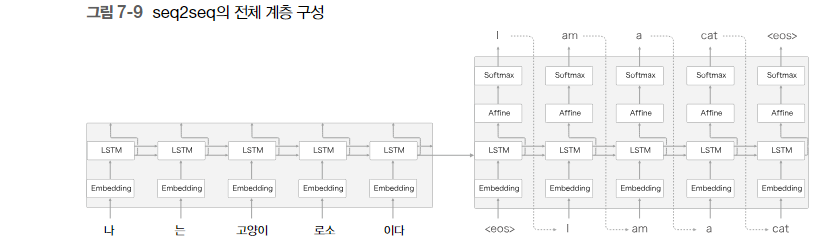

※ seq2seq 처리 과정 좋은 자료: https://glee1228.tistory.com/3

문제는 h가 고정 길이 벡터라는 것...<br>
입력 문장이 길어지면 필요한 정보가 벡터에 다 담기지 못함

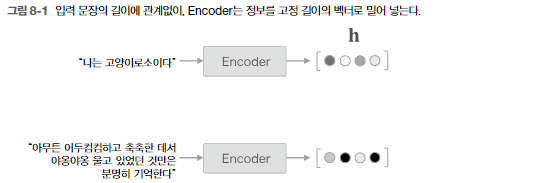

정리<br>
- fixed-size의 vector에 모든 정보를 저장하기 때문에 정보 손실 발생
- RNN의 고질적인 문제인 Vanishing Gradient(기울기 소실), 즉 Long-term problem이 존재

입력 문장의 길이가 길어질수록 성능이 떨어진다...
→ 어텐션이 해결

--------------------------------------------------------------------------------

우선, 전체적으로 'seq2seq'와 'seq2seq + 어텐션' 차이점 비교

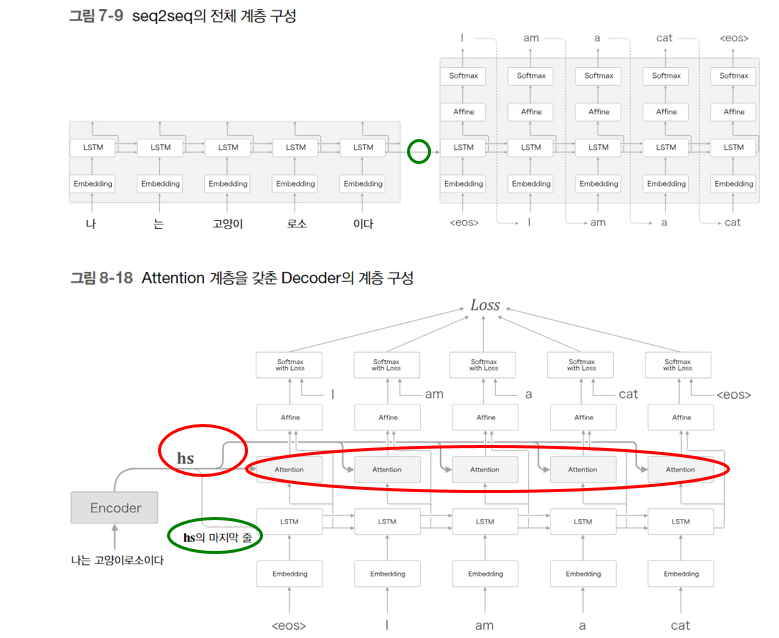

- 녹색: 같은 점
- 빨강: 달라진 점

--------------------------------------------------------------------------------

### 8.1.2 Encoder 개선

기존: LSTM 계층의 마지막 은닉 상태만 Decoder에 전달<br>
개선안: **Encoder 출력 길이를 입력 문장의 길이에 따라 바꿔야**...
        **각 시각 은닉 상태 벡터를 모두 전달**

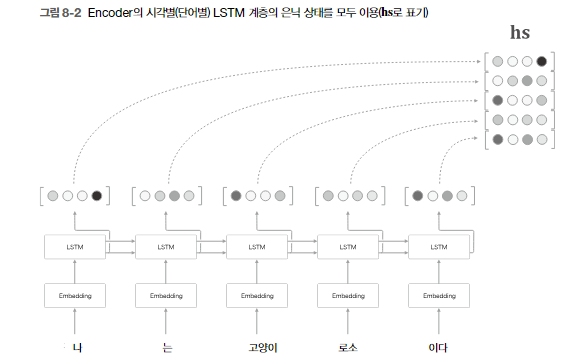

--------------------------------------------------------------------------------

※
NOTE(계층에서 hs를 추출하는 방법): 파이썬 코드 구현할 때,<br> RNN계층 초기화시 return_sequence 인수 설정으로 '모든 시각의 은닉 상태 벡터 변환', '마지막 은닉 상태 벡터만 변환' 선택 가능<br>
ex. @케라스 rnn = SimpleRNN(3, return_sequences=True)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;@케라스 lstm = LSTM(3, return_sequences=False, return_state=True)<br>

return_state가 True일 경우에는 return_sequences의 True/False 여부와 상관없이 마지막 시점의 은닉 상태를 출력

참고: https://wikidocs.net/106473

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional

In [3]:
# 배치 크기 1, 단어 벡터 차원 5, 문장 길이 4
train_X = [[[0.1, 4.2, 1.5, 1.1, 2.8], [1.0, 3.1, 2.5, 0.7, 1.1], [0.3, 2.1, 1.5, 2.1, 0.1], [2.2, 1.4, 0.5, 0.9, 1.1]]]
train_X = np.array(train_X, dtype=np.float32)
print(train_X.shape)

(1, 4, 5)


In [4]:
# SimpleRNN은 hidden state, last hidden state 반환
rnn = SimpleRNN(3, return_sequences=True, return_state=True)
hidden_states, last_state = rnn(train_X)

print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
print('last hidden state : {}, shape: {}'.format(last_state, last_state.shape))

hidden states : [[[-0.0110987  -0.7370418  -0.00795705]
  [ 0.98471916 -0.7011066   0.68770576]
  [ 0.9977923   0.6850279   0.9610782 ]
  [ 0.9444578   0.8880375  -0.961495  ]]], shape: (1, 4, 3)
last hidden state : [[ 0.9444578  0.8880375 -0.961495 ]], shape: (1, 3)


In [5]:
# lstm은 hidden state, last hidden state, cell state 반환
lstm = LSTM(3, return_sequences=True, return_state=True)
hidden_states, last_hidden_state, last_cell_state = lstm(train_X)

print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
print('last hidden state : {}, shape: {}'.format(last_hidden_state, last_hidden_state.shape))
print('last cell state : {}, shape: {}'.format(last_cell_state, last_cell_state.shape))

hidden states : [[[-0.04981408  0.08210462  0.08629318]
  [-0.1357893   0.171048   -0.0896764 ]
  [ 0.01298595  0.20942488  0.04928653]
  [-0.02108632  0.4184007  -0.03652273]]], shape: (1, 4, 3)
last hidden state : [[-0.02108632  0.4184007  -0.03652273]], shape: (1, 3)
last cell state : [[-0.03386355  0.9913031  -0.10586776]], shape: (1, 3)


--------------------------------------------------------------------------------

LSTM의 은닉 상태에는 직전에 입력된 단어들에 대한 정보가 많이 포함되어 있음<br>
고양이 벡터에는 '나', '는', '고양이'의 정보 담김<br>
cf. 고양이 주변 정보를 균형있게 담고 싶을 때 → 양방향 RNN or LSTM(뒷 절에서 설명)

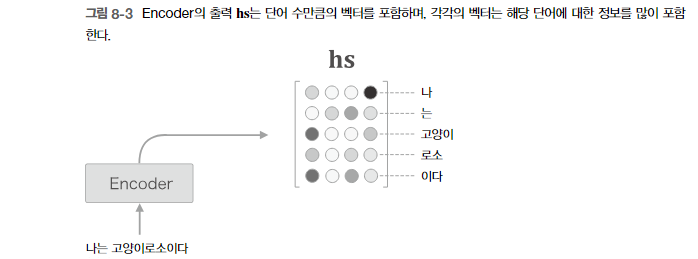

 ### 8.1.3 Decoder 개선①

단순한 seq2seq에서는 Encoder의 마지막 은닉 상태만 Decoder에 넘김

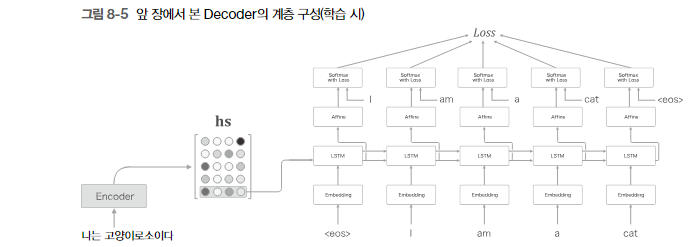

여기서...
우리가 영어로 번역할 때, '나=I', '고양이=cat'이라는 지식을 이용하고 있는데<br>
이렇게 '어떤 단어'에 주목하여 그 단어의 변환을 seq2seq로 재현할 수 있을지에 대한 의문...<br>
→ 입력, 출력 단어 중 어떤 단어끼리 서로 관련되어 있는가?에 대한 대응 관계를 학습시키고 싶다.

※ 얼라인먼트(alignment): '고양이=cat' 같이 단어 대응 관계를 나타내는 정보, 주로 수작업으로 만들었으나...

어텐션: 얼라인먼트라는 아이디어를 seq2seq에 자동으로 도입(수작업→기계에 의한 자동화)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;도착어 단어와 대응 관계에 있는 출발어 단어 정보를 골라내 그 정보를 이용하여 번역 수행<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;필요한 정보에만 주목하여 그 정보로부터 시계열 변환 수행

Attention 함수<br>
Attention(Q, K, V) = Attention value

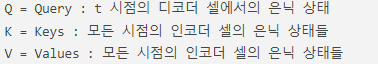

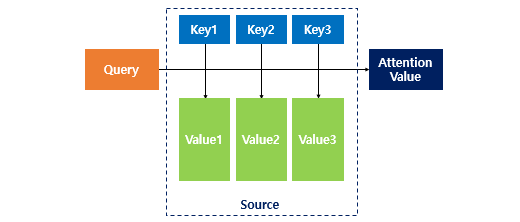

Encoder에서 K, V를 뽑았고...Decoder에서 Query를 가져와 어텐션 함수에 넣어볼 차례...

<어텐션 전체 구조>

'어떤 계산' = 어텐션 함수

hs = K, V

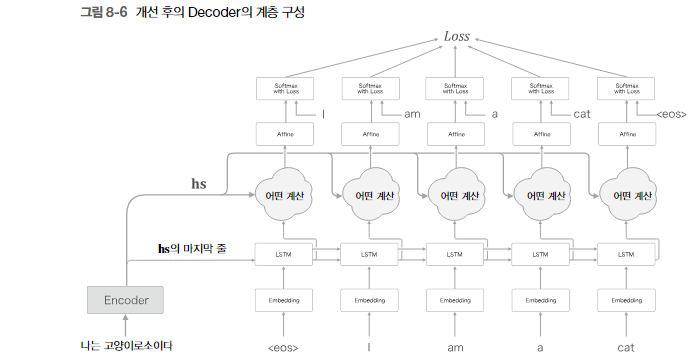

여기서 궁극적인 목적은 단어들의 얼라인먼트 추출!<br>
= 각 시각에서 Decoder에 입력된 단어와 대응 관계의 입력 단어 벡터를 hs에서 골라내겠다<br>
ex. Decoder 'I' 출력시 **'어떤 계산'을 통해** hs에서 '나'에 대응 벡터 선택

**이슈사항**<br>
!!! 선택하는 작업은 미분을 할 수 없다 !!!|<br>
신경망의 학습은 일반적으로 오차역전파법으로 이뤄지는데 미분이 불가능하면 오차역전파법을 사용할 수 없음

해결책<br>
하나를 선택하지 않고 전체를 선택하여 각 단어의 중요도를 나타내는 '가중치'를 별도로 계산하여 반영

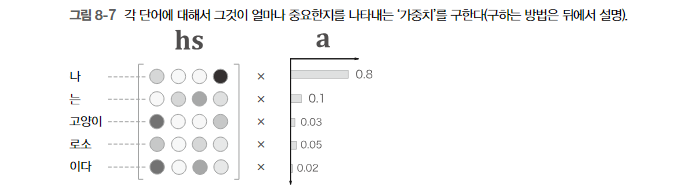

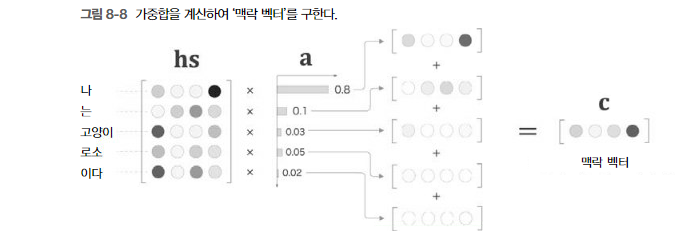

어텐션 가중치 a와 hs로부터 가중합(weighted sum)을 구해 '맥락 벡터'(Attention value) c를 구함<br>
맥락 벡터로 hs에서 번역에 필요한 정보를 선택하는 작업을 수행

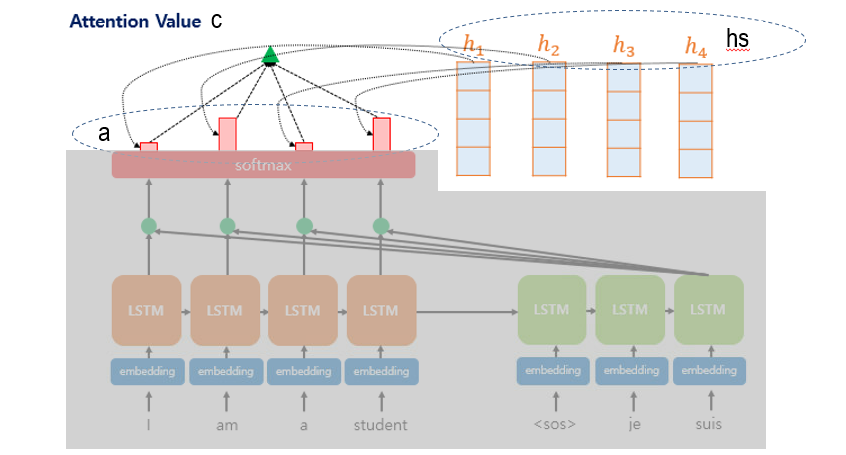

* 어텐션 가중치 a를 구하는 회색 영역은 뒷 절에서...

--------------------------------------------------------------------------------

어텐션 가중치 = Softmax(어텐션 스코어)

※ '어떤 계산' 내에서 어텐션 스코어를 구하는 방법이 여러가지 존재

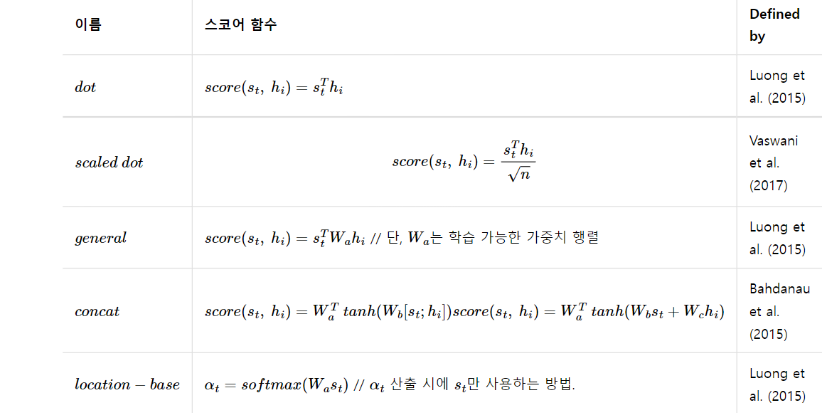

"dot-product Attention 예시"

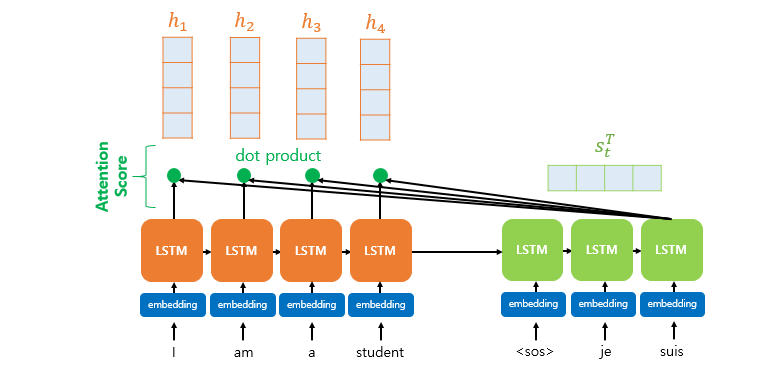

--------------------------------------------------------------------------------

가중합 구현 예시

In [6]:
import numpy as np

T, H = 5,4    # 시계열 길이 T=5, 은닉 상태 벡터의 원소 수 H=4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

# 가중치
ar = a.reshape(5,1).repeat(4, axis=1)
print(ar.shape)

t = hs*ar
print(t.shape)

c=np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


맥락 베터 길이는 은직 상태 벡터 원소 수와 동일<br>
은닉 상태 벡터 길이로 어떤 입력이 더 중요한 지 표현할 수 있음

※ 설명: ar = a.reshape(5,1).repeat(4, axis=1)

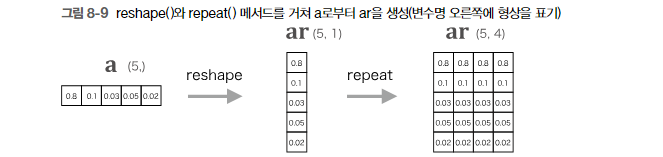

repeat를 사용하면 가독성 좋음<br>
구현 효율은 repeat() 보다 넘파이 브로드캐스트가 좋으나 가독성을 위해...

※ 굳이 repeat 함수 안써도 되는 상황 → 넘파이 브로드캐스트

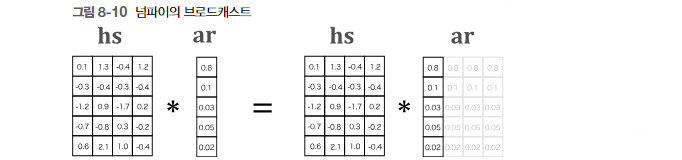

※ 미니 배치 처리 문제<br>
np.matmul(a,hs)로 가중합을 구하면 행렬 연산만 가능하므로 미니배치 처리로 확장이 어려움<br>
이때는 '텐서 곱' np.tensordot(), np.einsum() 적용할 수 있음

In [17]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)     # 차원 축 주의
# ar = a.reshape(N, T, 1) # 브로드캐스트 사용시

t = hs * ar
print(t.shape)

c = np.sum(t, axis=1)                         # 차원 축 주의
print(c.shape)

(10, 5, 4)
(10, 4)


계산 그래프

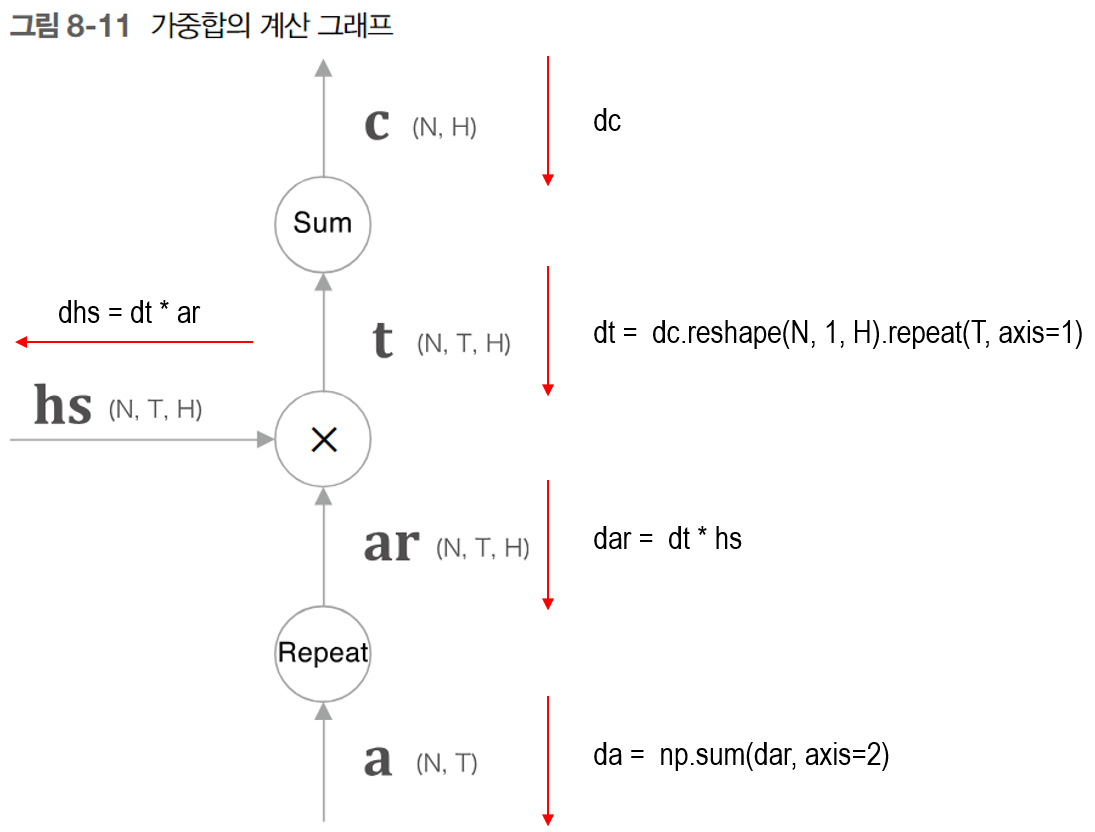

In [18]:
# Batch 크기 N, 시계열 길이 T, 은닉 상태 벡터의 원소 수 H

class WeightSum:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None

  def forward(self, hs, a):
    N, T, H = hs.shape
    ar = a.reshape(N, T, 1).repeat(H, axis = 2)
    t = hs*ar
    c = np.sum(t, axis=1)

    self.cache = (hs, ar)
    return c

  def backward(self, dc):
    hs, ar = self.cache
    N, T, H = hs.shape

    dt = dc.reshape(N, 1, H).repeat(T, axis=1) # sum 역전파, N개 batch T번 반복
    dar = dt * hs
    dhs = dt * ar
    da = np.sum(dar, axis=2) #repear 역전파,  N개 batch

    return dhs, da

※ Sum, Repeat 순전파, 역전파 구현

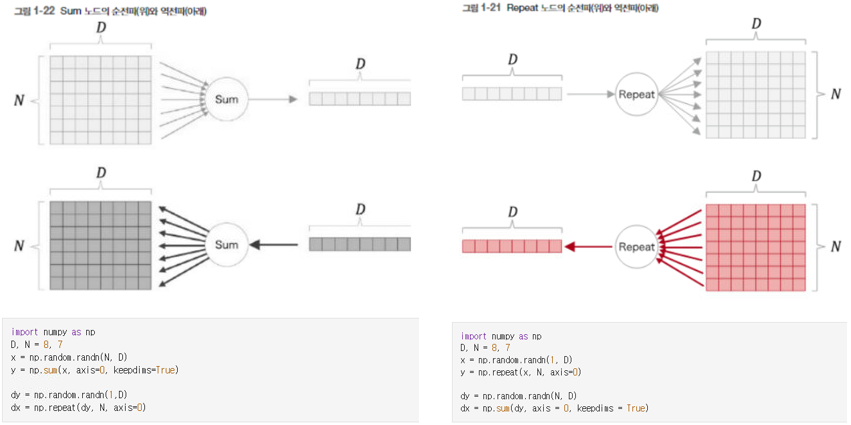

참고로 가중합을 구하는 과정에는 학습하는 매개 변수가 없음<br>
**책에 self.param = []으로 구현했다는 의미가 무엇인지...???**

### 8.1.4 Decoder 개선②

**어텐션 가중치(Attention Weight) a를 구하는 방법**

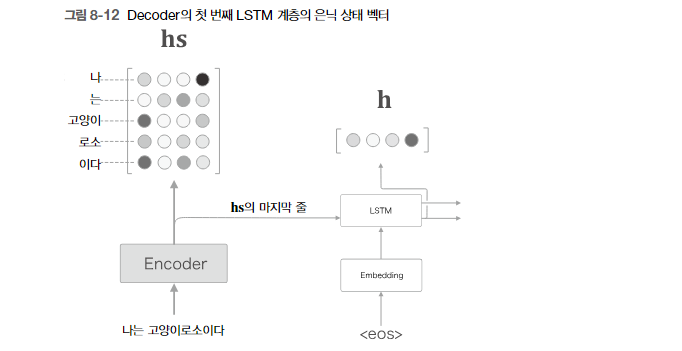

h가 hs 각 단어 벡터와 얼마나 비슷한지를 수치로 나타내야...<br>
여러가지 방법이 있을 수 있음<br>
cf. 내적 이용, 유사도 점수 출력 ...

내적을 이용하는 방법

벡터 a가 벡터 b에 투영된 길이
= 두 벡터가 얼마나 같은 방향을 향하고 있는가? = 두 벡터의 '유사도'를 표현하는 척도 중 하나

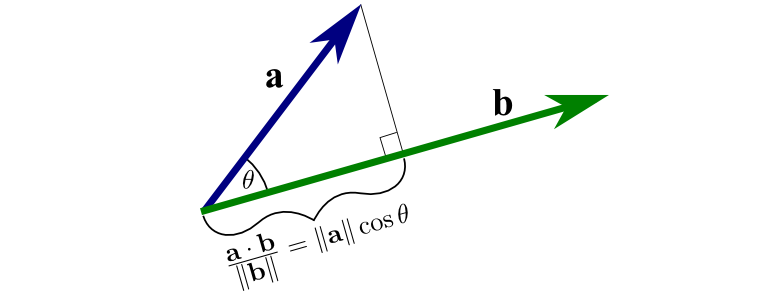

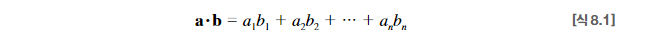

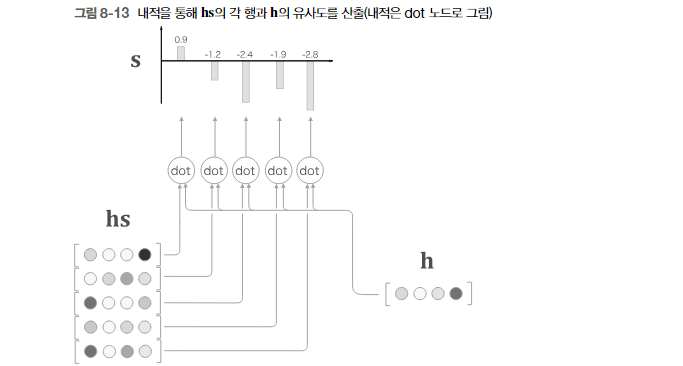

s 정규화하기 전의 값 = 점수 score = 어텐션 스코어<br>
소프트맥스 함수로 정규화 = 어텐션 가중치

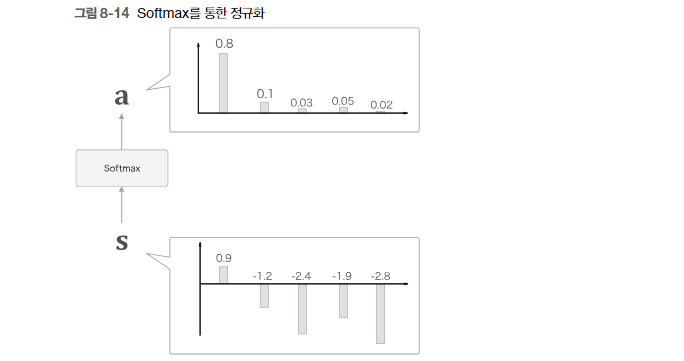

※ 이 책에서는 dot 연산을 행렬 원소 곱과 sum의 조합으로 구현<br>

In [20]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)
# hr = h.reshape(N, 1, H) # 브로드캐스트 사용시

t = hs*hr
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


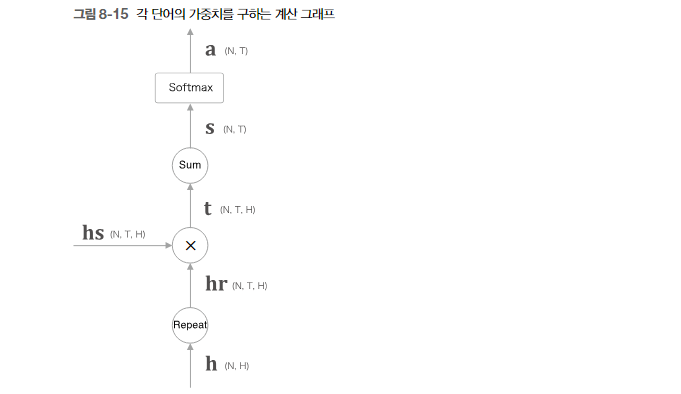

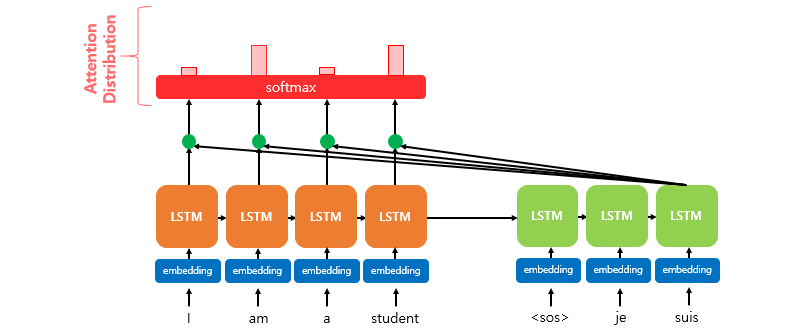

Attention Distribution 각각의 값이 어텐션 가중치(Attention Weight)

In [12]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [21]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

### 8.1.5 Decoder 개선③

8.1.4에서 Attention Weight 계층: Encoder가 출력하는 각 단어 벡터 hs에 주목해
해당 단어의 가중치 a 계산<br>
8.1.3에서 Weight Sum 계층: a와 hs의 가중합을 구하고 그 결과를 맥락 벡터 c로 출력

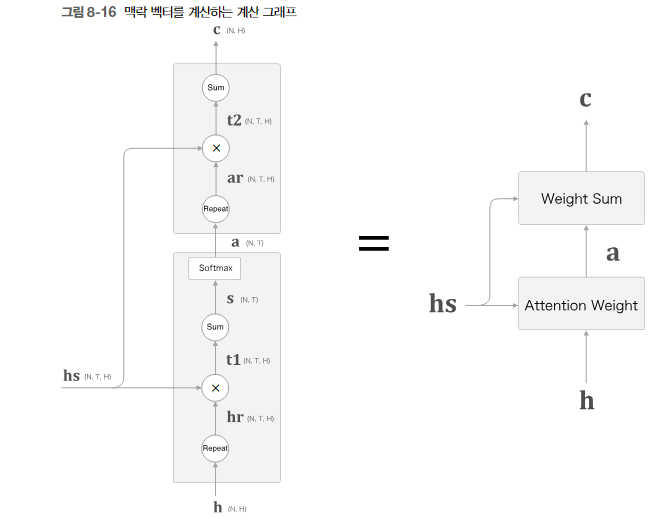

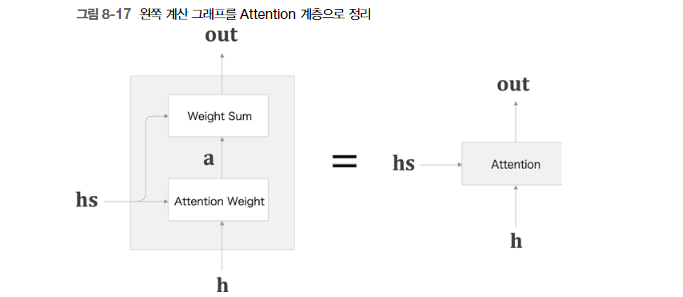

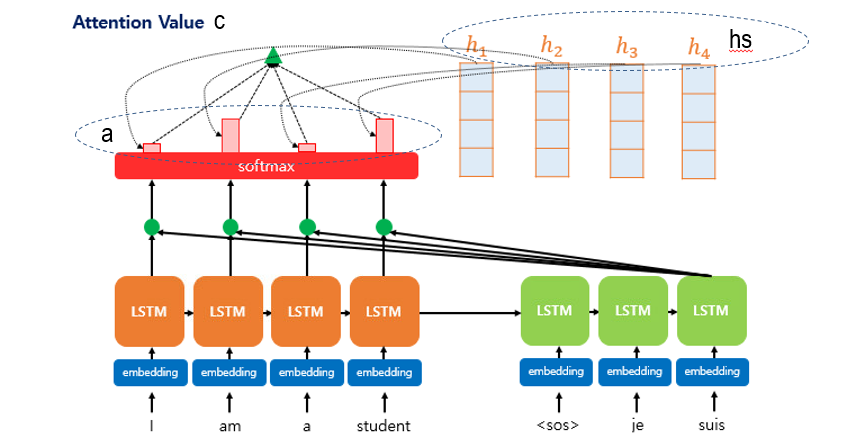

In [22]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

attention_weight에 각 단어의 가중치를 나중에 참조할 수 있도록 저장

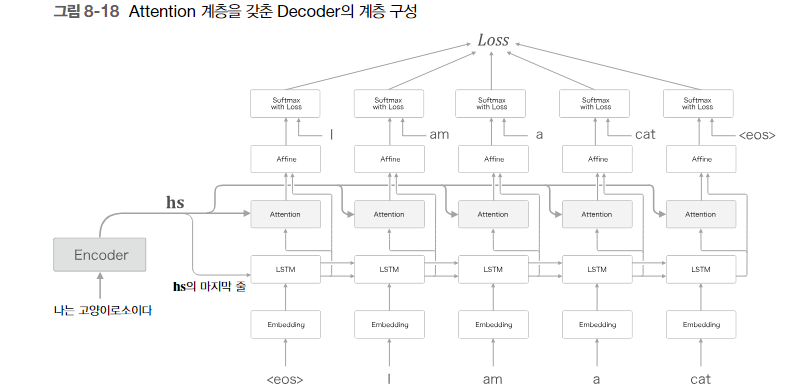

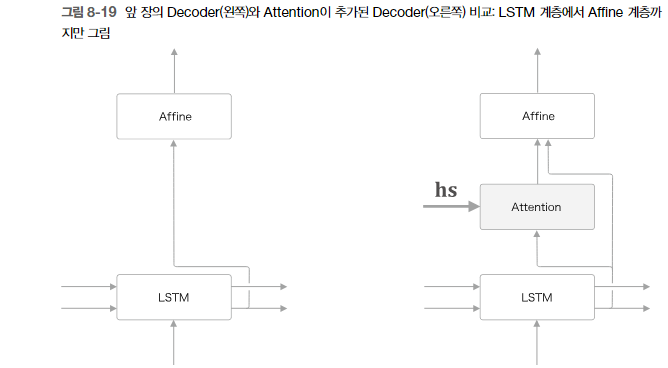

Affine 계층에 맥락 벡터와 은닉 상태 벡터가 입력됨

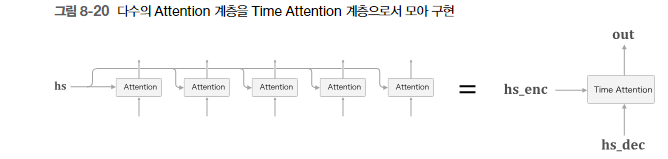

In [23]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## 8.2 어텐션을 갖춘 seq2seq 구현

### 8.2.1 Encoder 구현

In [24]:
import sys
sys.path.append('..')
from common.time_layers import *
from code_ch8.seq2seq import Encoder, Seq2seq
from code_ch8.attention_layer import TimeAttention

class AttentionEncoder(Encoder):                  # Encoder 상속
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 8.2.2 Decoder 구현

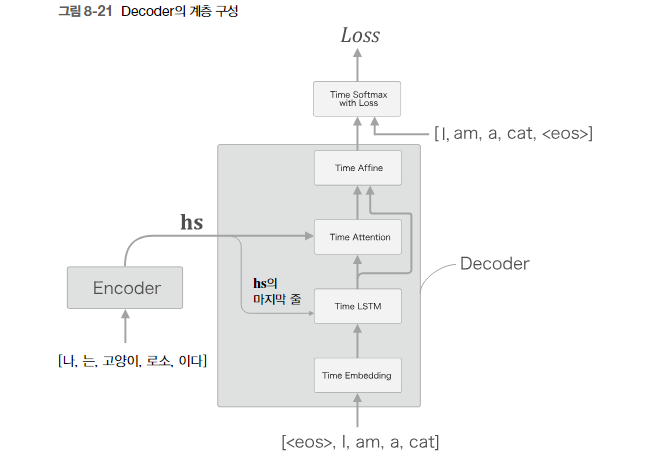

In [25]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()  # Attention 레이어
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)  # context vector
        out = np.concatenate((c, dec_hs), axis=2)  # context_vector & lstm h_t
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    # 새로운 단어열 생성
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

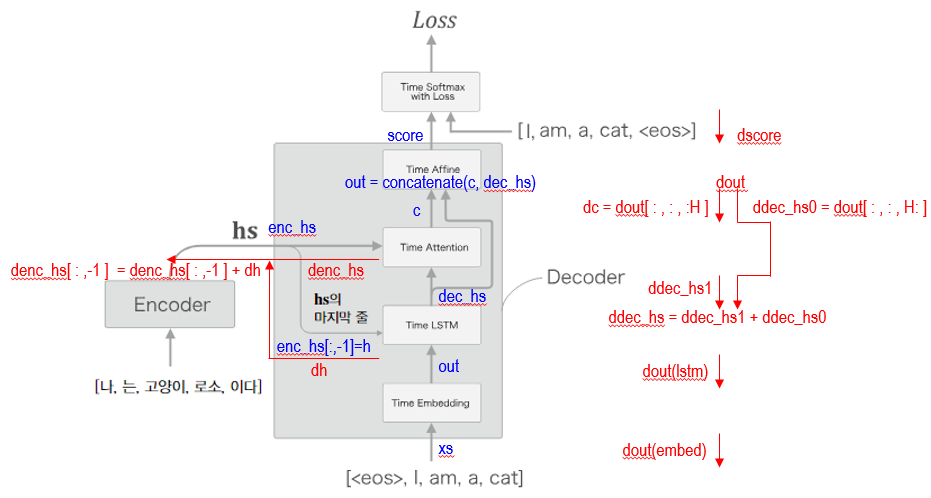

### 8.2.3 seq2seq 구현

cf. Seq2seq 비교

In [26]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 8.3 어텐션 평가

※ 번역용 데이터셋 WMT: 영어 to 프랑스어, 독일어

### 8.3.1 날짜 형식 변환 문제

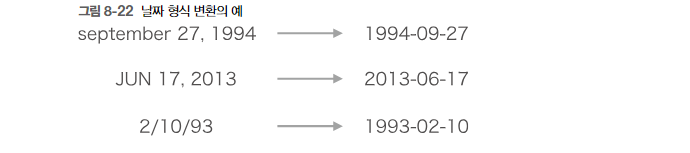

dataset/date.txt<br>
특정: 입력 문장 길이 통일(공백 문자 패딩), 입출력 구분자('_'), 출력 끝 구분자 없음

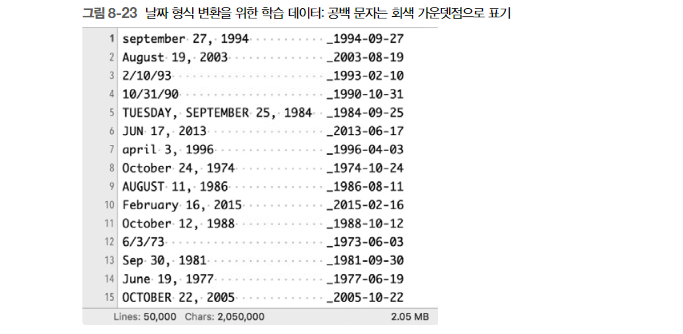

### 8.3.2 어텐션을 갖춘 seq2seq의 학습

In [6]:
import sys
sys.path.append('..')
import os
import numpy


id_to_char = {}
char_to_id = {}


def _update_vocab(txt):
    chars = list(txt)

    for i, char in enumerate(chars):
        if char not in char_to_id:
            tmp_id = len(char_to_id)
            char_to_id[char] = tmp_id
            id_to_char[tmp_id] = char


def load_data(file_name='addition.txt', seed=1984):
    # file_path = os.path.dirname(os.path.abspath(__file__)) + '/' + file_name
    file_path = '/content/drive/MyDrive/Colab Notebooks/'+file_name

    if not os.path.exists(file_path):
        print('No file: %s' % file_name)
        return None

    questions, answers = [], []

    for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx])
        answers.append(line[idx:-1])

    # 어휘 사전 생성
    for i in range(len(questions)):
        q, a = questions[i], answers[i]
        _update_vocab(q)
        _update_vocab(a)

    # 넘파이 배열 생성
    x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
    t = numpy.zeros((len(questions), len(answers[0])), dtype=numpy.int)

    for i, sentence in enumerate(questions):
        x[i] = [char_to_id[c] for c in list(sentence)]
    for i, sentence in enumerate(answers):
        t[i] = [char_to_id[c] for c in list(sentence)]

    # 뒤섞기
    indices = numpy.arange(len(x))
    if seed is not None:
        numpy.random.seed(seed)
    numpy.random.shuffle(indices)
    x = x[indices]
    t = t[indices]

    # 검증 데이터셋으로 10% 할당
    split_at = len(x) - len(x) // 10
    (x_train, x_test) = x[:split_at], x[split_at:]
    (t_train, t_test) = t[:split_at], t[split_at:]

    return (x_train, t_train), (x_test, t_test)


def get_vocab():
    return char_to_id, id_to_char

In [7]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks'

<ipython-input-6-d9dad5a98c16>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
<ipython-input-6-d9dad5a98c16>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 11[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 18[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 28[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 36[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 47[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 55[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 65[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 74[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 83[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 93[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 100[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 110[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 118[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 130[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 141[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 149[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 159[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


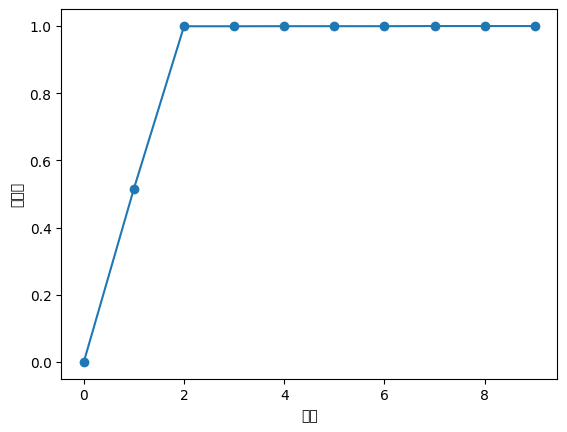

In [8]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from common.np import *
# from common.sequence import *
# from dataset.sequence import * #sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from code_ch8.attention_seq2seq import AttentionSeq2seq
from code_ch8.seq2seq import Seq2seq
from code_ch8.peeky_seq2seq import PeekySeq2seq

# 데이터 읽기
# (x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
(x_train, t_train), (x_test, t_test) = load_data('date.txt')
# char_to_id, id_to_char = sequence.get_vocab()
char_to_id, id_to_char = get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)       # 입력 문장을 반전

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

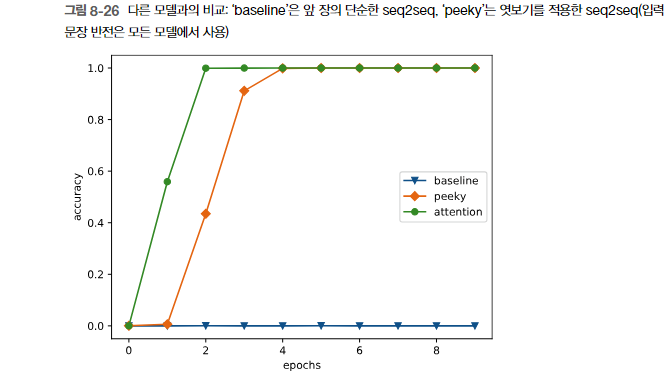

### 8.3.3 어텐션 시각화

어텐션이 시계열 변환을 수행할 때, 어느 원소에 주의를 기울이는지 눈으로 살펴보기 위해...

Time Attention 계층에 있는 attention_weights에 각 시각의 어텐션 가중치 저장

<ipython-input-6-d9dad5a98c16>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
<ipython-input-6-d9dad5a98c16>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

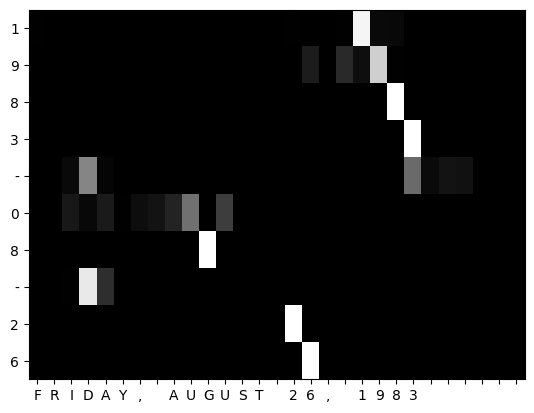

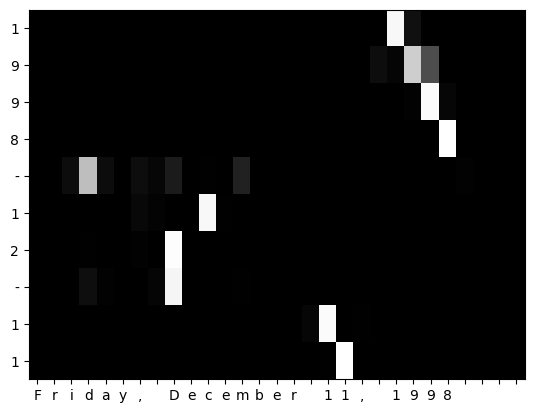

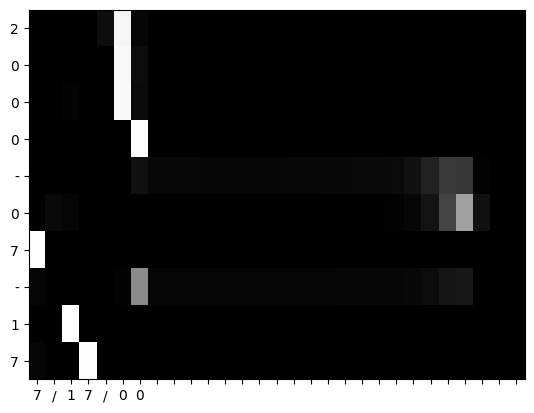

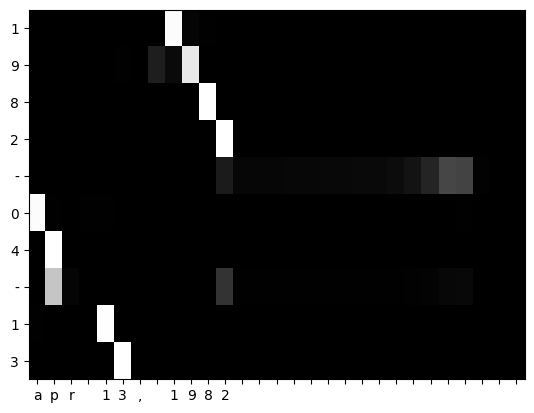

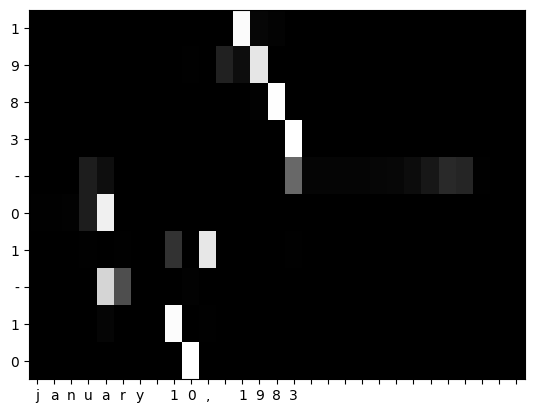

In [9]:
import sys
sys.path.append('..')
import numpy as np
# from dataset import sequence
import matplotlib.pyplot as plt
from code_ch8.attention_seq2seq import AttentionSeq2seq


# (x_train, t_train), (x_test, t_test) = \
#     sequence.load_data('date.txt')
# char_to_id, id_to_char = sequence.get_vocab()

(x_train, t_train), (x_test, t_test) = load_data('date.txt')
char_to_id, id_to_char = get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

## 8.4 어텐션에 관한 남은 이야기

### 8.4.1 양방향 RNN

앞 절 까지에서는<br>
Encoder의 LSTM 은닉 상테 벡터 hs에 저장된 벡터들이 왼쪽 단어 정보만 포함되어있음

단어 주변 정보를 균형 있게 담고 싶을 때,<br>
양방향 LSTM(양방향 RNN) 적용

두 LSTM계층의 은닉 상태를 연결시켜 최종 은닉 상태 벡터 도출<br>
cf. 두 LSTM계층의 은닉 상태를 '합', '평균' 내는 방법

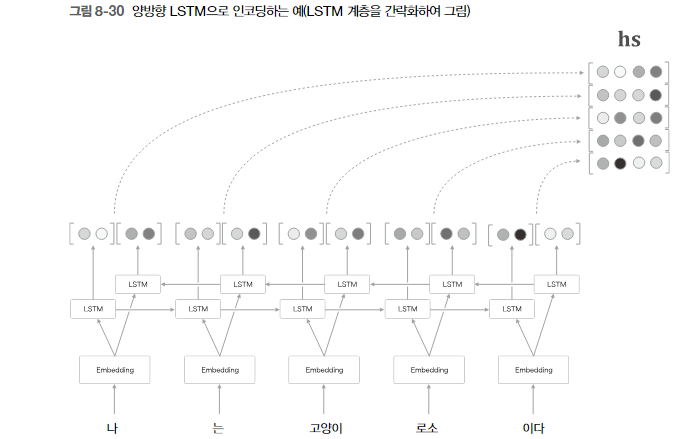

2개 LSTM계층에서 각각 계층에 주는 단어의 순서를 서로 바꾸면 됨

In [ ]:
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

In [ ]:
import numpy as np
a=np.array([[1,2,3],[4,5,6]])

In [ ]:
a[:,::-1]

array([[3, 2, 1],
       [6, 5, 4]])

### 8.4.2 Attention 계층 사용 방법

앞 절까지는 Attention 꼐층을 LSTM과 Affine 계층 사이에 삽이하여 사용

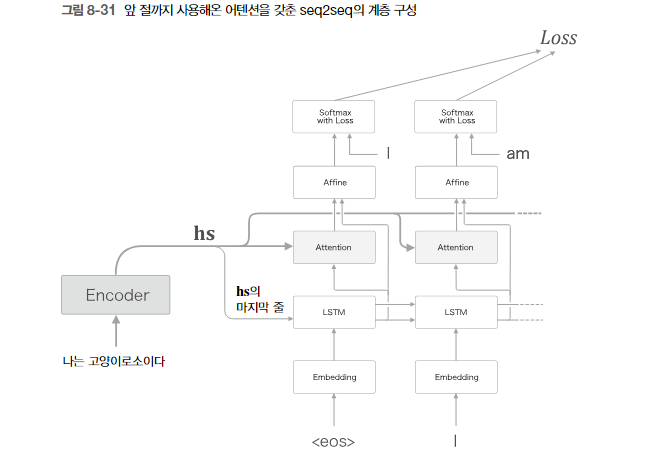

Attention 계층 위치 다른 곳<br>
Attention 계층 출력(맥락 벡터)을 어디서 사용하는지...

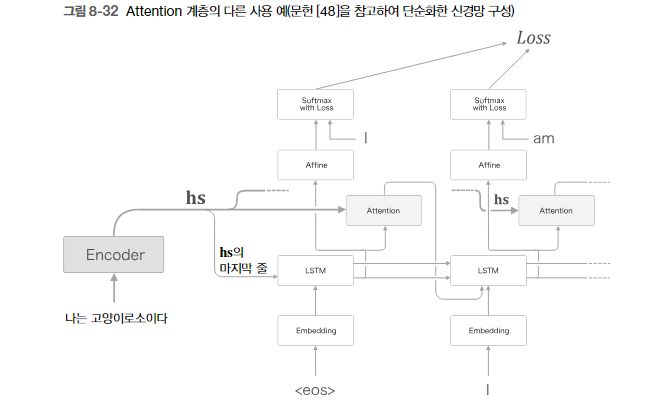

### 8.4.3 seq2seq 심층화와 skip 연결

RNN계층이나 LSTM계층을 깊게 쌓으면 표현력 높은 모델을 만들 수 있음

3층 LSTM 예시

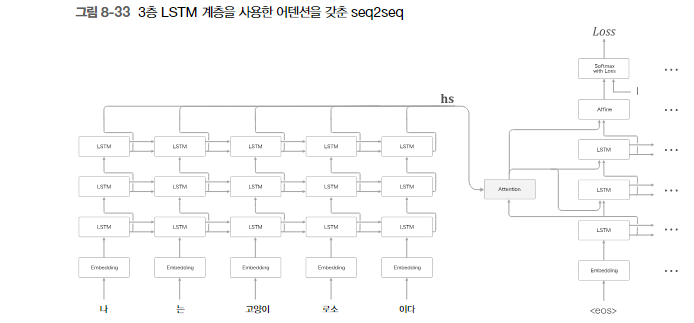

일반적으로 Encoder와 Decoder에 같은 층수의 LSTM 계층을 이용<br>
단, Attention 계층의 사용법은 여러 변형이 있을 수 있음

계층을 깊게 할 경우 일반화 성능을 떨어뜨리지 않은 것이 중요...(오버피팅 문제???)<br>
이 때, 드롭아웃과 가중치 공유 등의 기술이 효과적

Skip 연결(skip connection, residual connection, short-cut)<br>
덧셈은 역전파 시 기울기를 그래도 흘려보내기 때문에 층이 깊어져도 기울기 소실이 되지않고 전파되어 좋은 학습을 기대<br>
→ 깊이 방향 기울기 소실에 효과적<br>
cf. RNN 계층의 역전파에서 **시간 방향**에서의 기울기 소실, 폭발 대응 방안
- 기울기 소실: LSTM과 GRU등 게이트가 달린 RNN으로 대응
- 기울기 폭발: 기울기 클리핑으로 대응

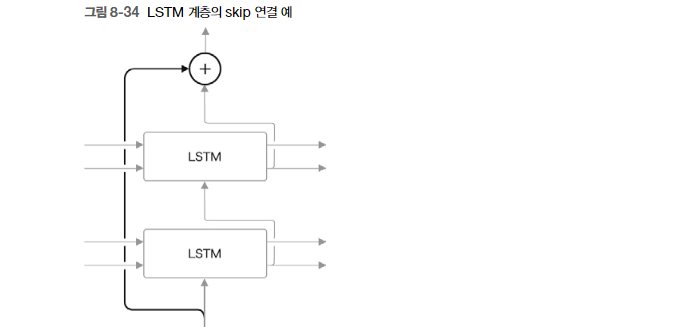

## 8.5 어텐션 응용
#### 어텐션 적용 사례

### 8.5.1 구글 신경망 기계번역(Google Neural Machine Trnslation, GNMT)

규칙 기반 번역 → 용례 기반 번역 → 통계 기반 번역→ 신경망 기계 번역(Neural Machine Translation, NMT)

GNMT는 LSTM 계층의 다층화, 양방향 LSTM, skip 연결 등 적용.<br>
학습 시간 단축을 위해 다수 GPU로 분산 학습 수행

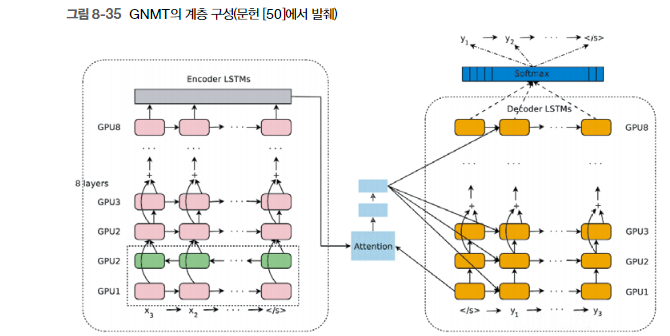

※ GNMT는 낮은 빈도 단어 처리, 추론 고속화를 위한 양자와 등 다양한 연구 진행 중

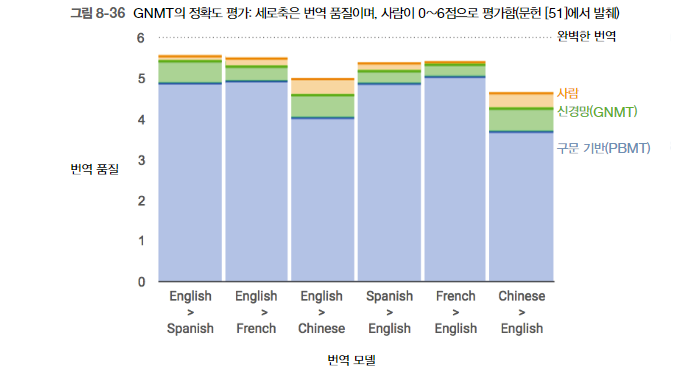

### 8.5.2 트랜스포머
#### 'Attention is all you need'

RNN의 단점 중 병렬 처리 문제를 해결하기 위해...<br>
RNN은 이전 시각에 계산한 결과를 이용하여 순서대로 계산 진행...

트랜스포머는 어텐션으로 구성되는 Self-attention(자기 자신에 대한 주목)이 핵심<br>
하나의 시계열 데이터를 대상으로 하나의 시계열 데이터 내에서 각 원소가 다른 원소들과 어떻게 관련되는지

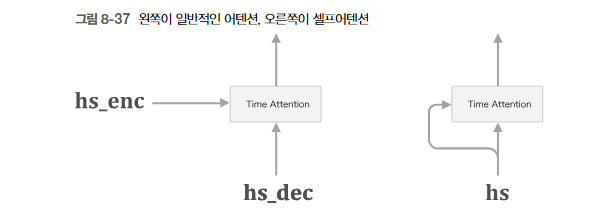

Self-attention은 하나의 시계열 데이터 내에서 원소 간 대응 관계 구해짐

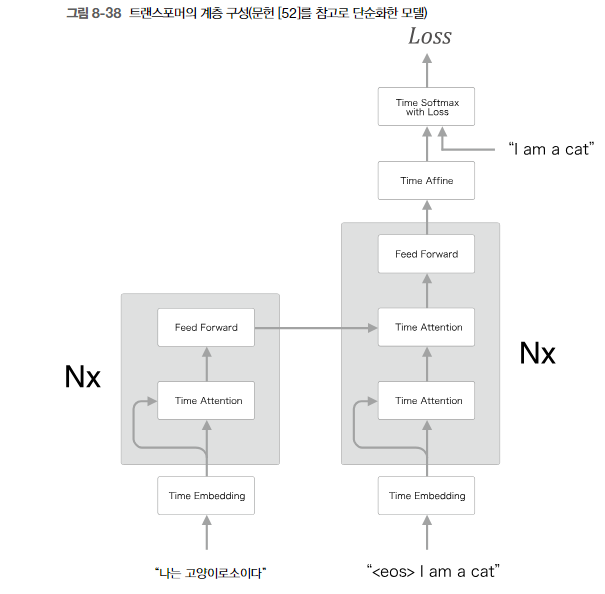

트랜스포머는 RNN 대신 어텐선 사용

Feed Forward 계층은 시간 방향으로 독립적으로 처리하는 신경망<br>
은닉층 1개이고 활성화 함수로 ReLU를 이용한 완전연결계층 신경망 이용<br>
Nx는 N겹의 계층을 의미

트랜스포머는 계산량을 줄이고 GPU를 이용한 병렬 계산의 혜택

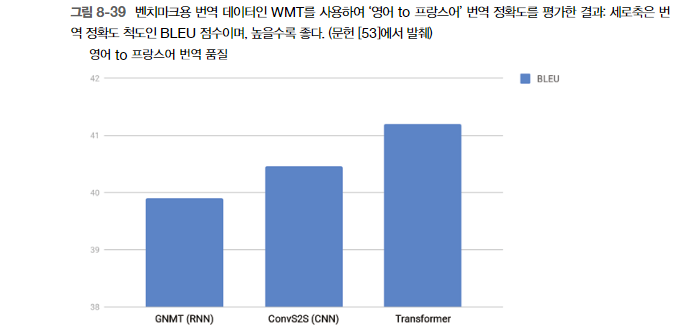

※ ConvS2S: 합성곱 계층을 이용한 seq2seq

### 8.5.3 뉴럴 튜링 머신(NTM)

외부 메모리를 통한 확장

RNN이나 LSTM은 내부 상태를 활용하여 시계열 데이터 기억<br>
하지만 길이가 고정이라 저장 정보량이 제한적<br>
→ 외부 메모리에 필요한 정보를 적절하게 기록

RNN의 외부에 정보 저장용 메모리 기능을 배치하고 어텐션을 이용하여 그 메모리로부터 필요한 정보를 읽거나 쓰는 방법<br>
→ Neural Turing Machine(NMT)<br>
→ Differentiable Neural Computer로 메모리 조직을 더욱 강화

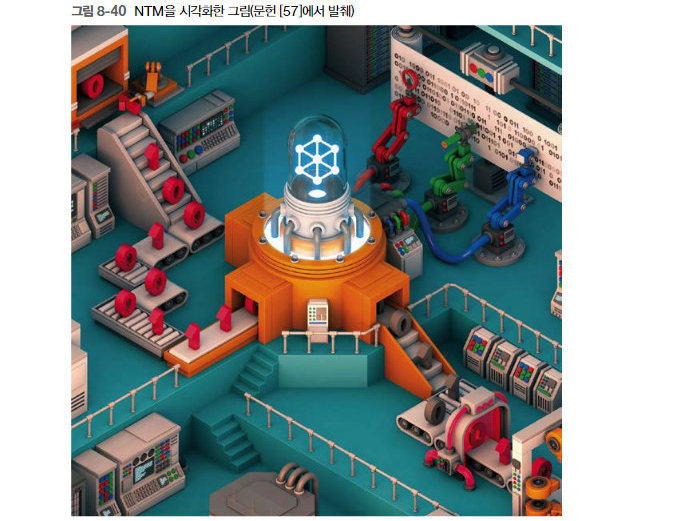

외부 메모리를 읽고 쓰면서 시계열 데이터를 처리하는데 메모리 조작을 미분 가능한 계산으로 구축하여 메모리 조작 순서도 데이터로부터 학습 가능

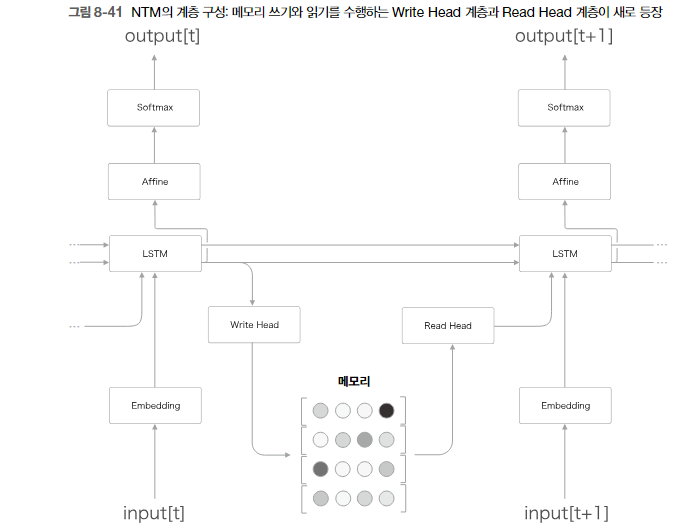

Write Head와 Read Head 계층에 어텐션 사용<br>
어텐션을 사용하여 모든 번지에 담긴 테이터를 선택하도록하고 각 데이터의 기여도를 나타내는 가중치를 이용하여 선택

NTM 어텐션
- 콘텐츠 기반 어텐션: 입력으로 주어진 어느 벡터(query)와 비슷한 벡터를 메모리로부터 찾아내는 용도
- 위치 기반 어텐션: 이전 시각에서 주목한 메모리 위치(메모리의 각 위치에 대한 가중치)를 기준으로 그 전후로 이동(시프트)하는 용도로 사용, 1차원 합성곱 연산으로 구현, 메모리 위치를 하나씩 옮겨가며 읽어 나가는 움직임 재현 가능

긴 시계열을 기억하는 문제와 정렬 등의 문제를 NTM이 해결